In [25]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
sns.set_style('darkgrid')

In [37]:
# Load up the data.
#ga stands for gender/age
gatrain = pd.read_csv('gender_age_train.csv', index_col='device_id')
gatest = pd.read_csv('gender_age_test.csv', index_col = 'device_id')
# 
phone_brands = pd.read_csv('phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
phone_brands = phone_brands.drop_duplicates('device_id',keep='first').set_index('device_id')
# Location data
events = pd.read_csv('events.csv', parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv('app_labels.csv')
labelcats = pd.read_csv('label_categories.csv', index_col='label_id',squeeze=True)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Exploratory Data Analysis

In [33]:
print('Shape of gatrain data set:')
print(gatrain.shape)
gatrain.head()

Shape of gatrain data set:
(74645, 3)


,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38
-4938849341048082022,M,30,M29-31
245133531816851882,M,30,M29-31


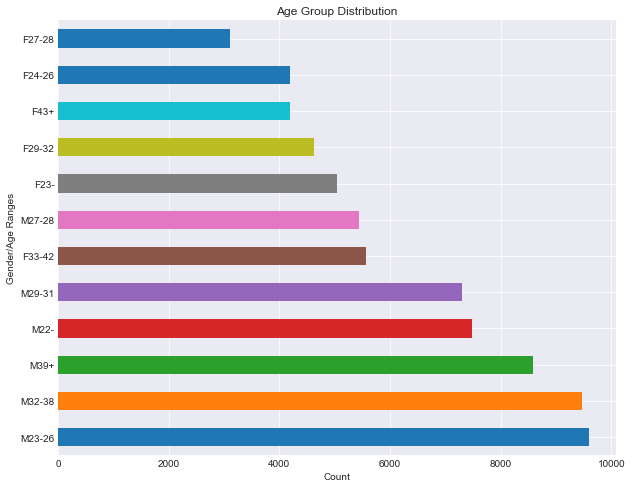

In [27]:
# Distribution of age based users.
fig,ax = plt.subplots(figsize=(10,8))
gatrain.group.value_counts().plot(kind='barh')
plt.title('Age Group Distribution')
plt.ylabel('Gender/Age Ranges')
plt.xlabel('Count');

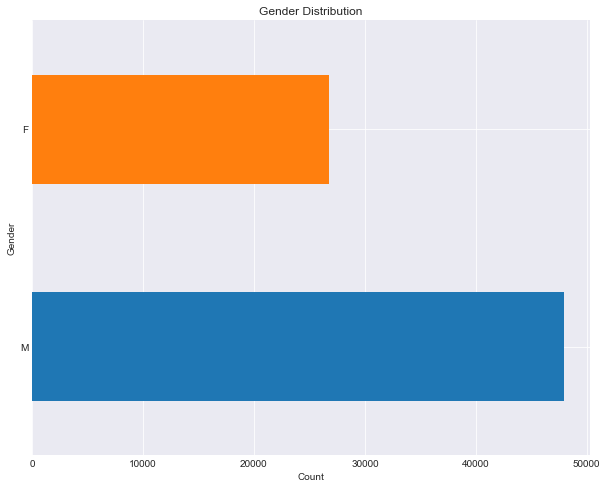

In [26]:
# Gender Distribution
fig,ax = plt.subplots(figsize=(10,8))
gatrain.gender.value_counts().plot(kind='barh')
plt.title('Gender Distribution')
plt.xlabel('Count')
plt.ylabel('Gender');

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


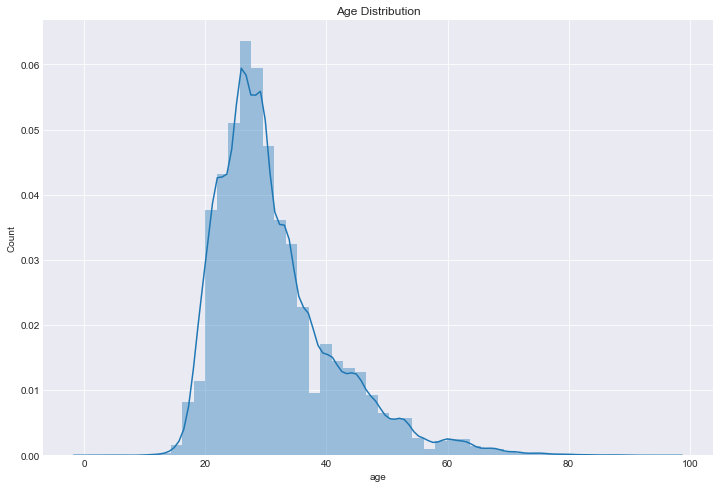

In [32]:
# Age Distribution
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Age Distribution')
plt.xlabel('Ages')
plt.ylabel('Count')
sns.distplot(gatrain.age);

In [38]:
print('Shape of phone brands data set:')
print(phone_brands.shape)
phone_brands.head()

Shape of phone brands data set:
(186716, 2)


,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2
